In [2]:
import numpy as np
from scipy.optimize import curve_fit, root

# visualization tools
import matplotlib.pyplot as plt
from qiskit.visualization.bloch import Bloch

import qiskit.pulse as pulse
from qiskit.pulse import Schedule, Play, Acquire, DriveChannel, AcquireChannel, MemorySlot
from qiskit.pulse.library import Gaussian, GaussianSquare, Waveform
from qiskit.compiler import assemble
import qiskit

from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# function for constructing duffing models
from qiskit.providers.aer.pulse import duffing_system_model

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

In [3]:
# cutoff dimension
dim_oscillators = 3

# frequencies for transmon drift terms, harmonic term and anharmonic term
# Number of oscillators in the model is determined from len(oscillator_freqs)
oscillator_freqs = [5.0e9]
anharm_freqs = [-0.33e9]

# drive strengths
drive_strengths = [0.02e9]

# specify coupling as a dictionary (qubits 0 and 1 are coupled with a coefficient 0.002e9)
coupling_dict = {}

# sample duration for pulse instructions 
dt = 1e-9

# create the model
one_qubit_model = duffing_system_model(dim_oscillators=dim_oscillators,
                                       oscillator_freqs=oscillator_freqs,
                                       anharm_freqs=anharm_freqs,
                                       drive_strengths=drive_strengths,
                                       coupling_dict=coupling_dict,
                                       dt=dt)

In [74]:
nQ = 1
rb_pattern = [[0]]
rb_opts = {}
rb_opts['length_vector'] = [1, 5, 10, 15, 20, 25, 30]
rb_opts['nseeds'] = 5
rb_opts['rb_pattern'] = rb_pattern
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

### define instruction map
in order to avoid calibration (just for making the test faster and shorter), take the instruction map from real one-qubit device

In [5]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
real_backend = provider.get_backend('ibmq_armonk')
backend_defaults = real_backend.defaults()

/Users/dekelm/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [27]:
real_inst_map = backend_defaults.instruction_schedule_map
basis_gates = ['id', 'u1', 'u2', 'u3']
schedule3 = Schedule()
meas_map = [[0]]

In [28]:
backend_sim = PulseSimulator()

In [75]:
schedules = []
for circ in rb_circs:
    scheds_seed = []
    for ii, circ_seed in enumerate(circ):
        print('-seed[%d]' % ii)
        circ_seed_transpiled = qiskit.transpile(circ_seed, backend_sim, basis_gates=basis_gates)
        scheds_seed.append(qiskit.schedule(circ_seed_transpiled, backend_sim, inst_map=real_inst_map,
                                           meas_map=meas_map))
    schedules.append(scheds_seed)

-seed[0]
-seed[1]
-seed[2]
-seed[3]
-seed[4]
-seed[5]
-seed[6]
-seed[0]
-seed[1]
-seed[2]
-seed[3]
-seed[4]
-seed[5]
-seed[6]
-seed[0]
-seed[1]
-seed[2]
-seed[3]
-seed[4]
-seed[5]
-seed[6]
-seed[0]
-seed[1]
-seed[2]
-seed[3]
-seed[4]
-seed[5]
-seed[6]
-seed[0]
-seed[1]
-seed[2]
-seed[3]
-seed[4]
-seed[5]
-seed[6]


In [76]:
# compute frequencies from the Hamiltonian
qubit_lo_freq = one_qubit_model.hamiltonian.get_qubit_lo_from_drift()

change the qubit frequency from the calculated one, to add noise to the system

In [77]:
qubit_lo_freq[0] += 10.0e6
print(qubit_lo_freq)

[5010000000.0]


In [79]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [80]:
backend_options = {'solver_options' : {'method' : 'scipy-RK45'}}

results = []
for schedule in schedules: 
    # assemble the qobj
    qobj = assemble(schedule,
                    backend=backend_sim,
                    qubit_lo_freq=qubit_lo_freq,
                    meas_level=1, 
                    meas_return='avg',
                    shots=512)
    
    results.append(backend_sim.run(qobj, one_qubit_model, backend_options).result(timeout=3600))

/Users/dekelm/opt/anaconda3/lib/python3.7/site-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,
/Users/dekelm/opt/anaconda3/lib/python3.7/site-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,
/Users/dekelm/opt/anaconda3/lib/python3.7/site-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,
/Users/dekelm/opt/anaconda3/lib/python3.7/site-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,
/Users/dekelm/opt/anaconda3/lib/python3.7/site-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported

In [81]:
rbfitter = rb.fitters.RBFitter(results, xdata, rb_opts['rb_pattern'])

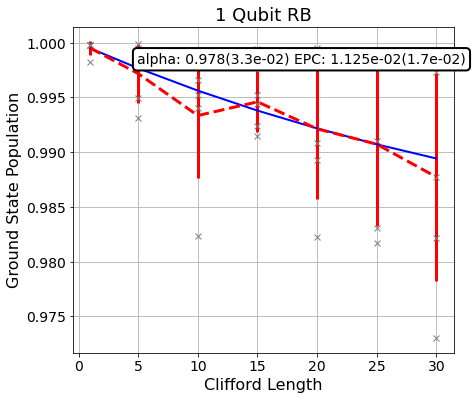

In [82]:
plt.figure(figsize=(15, 6))

for i in range(1):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    rbfitter.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

plt.show()

calculate the leakage parameters

In [83]:
A = rbfitter._fit[0]["params"][0]
alpha = rbfitter._fit[0]["params"][1]

In [84]:
(1-A)*(1-alpha)  #L1

0.02201524216936448

In [85]:
(A)*(1-alpha)  #L2

0.0004788367537945434